In [2]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import network_module as nm
import argparse

def print_csv(filename, data):
    with open(filename, 'wb') as out:
        for t in data:
            out.write('{}\t{}\n'.format(*t))


# layer_params = sys.argv[1:]

# netname = 'mnist-fc-784-'
# for width in layer_params:
#     netname += '{}-'.format(width)
# netname += '10'
reg = 0
L1 = False
L2 = False
L05 = False
netname = 'conv5-3x3-maxpool-100'
data_source = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

def loadmnist():
    import cPickle, gzip, numpy

    # Load the dataset
    f = gzip.open('./MNIST_data/mnist.pkl.gz', 'rb')
    sets = cPickle.load(f)
    f.close()
    res = []
    for set in sets:
        set[0].shape = (-1, 1, 28, 28)

        label = set[1]
        onehot = np.zeros((label.size, label.max() + 1))
        onehot[np.arange(label.size), label] = 1
        res.append((set[0].reshape(-1, 1, 28, 28), onehot))
    return res


print 'Loading MNIST images...'
train, test, _= loadmnist()


# train = (np.zeros((50, 1, 20, 20)), np.zeros((50 ,1 ,8 , 8)))
# train[0][0,:,5,5] = 0.5
# train[1][0,:,4,4] = 1

def loadnetwork(network_source):
    global nn
    nn = nm.load(network_source)


print 'Constructing network...'
#########################
# NETWORK DEFINITION
nn = nm.network(in_shape=train[0][0].shape, criterion='MSE')
nn.add_conv(1, (3, 3))

#########################
print nn
    
def imshow(im, cmap='Greys', interpol='None'):
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    if len(im.shape) == 3:
        for i, x in enumerate(im, 1):
            plt.subplot(1, len(im), i)
            plt.imshow(x.squeeze(), cmap=cmap, interpolation=interpol)
            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.gca().yaxis.set_major_locator(plt.NullLocator())
    if len(im.shape) == 4:
        for irow, xrow in enumerate(im, 0):
            for icol, x in enumerate(xrow, 1):
                # print '\r  ', len(im), len(xrow), irow * len(xrow) + icol
                plt.subplot(len(im), len(xrow), irow * len(xrow) + icol)
                plt.imshow(x.squeeze(), cmap=cmap, interpolation=interpol)
                plt.gca().xaxis.set_major_locator(plt.NullLocator())
                plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.show()
    return im.shape


def visualise_layer(layer_ind=4, top=9, epoch=10, activation_set=train[0], biased=False, rate=0.05):
    test = nn.grad_ascent(
        layer_ind=layer_ind, 
        activation_set=activation_set, 
        top=top, 
        epoch=epoch, 
        biased=biased)
    test = test.reshape((top,) + nn[layer_ind].shape + (28, 28))
    test = np.concatenate((test, test.mean(axis=0)[np.newaxis, :]), axis=0)
    return test

def max_act(lay_ind, top=9):
    return test[0][nn.max_act(lay_ind, test[0], top)].squeeze()



Loading MNIST images...
Constructing network...
Network ID: 139735903003664
Network layout:
------------------------------
	INPUT  (1, 28, 28)
	   |
	   |
	  |1|
  convolution  (1, 26, 26)   ->   kernels: (1, 1, 3, 3)
	   |
	   |
	  |2|
  	OUTPUT  (1, 26, 26)   ->   CRITERION  (MSE)
------------------------------


In [18]:
from scipy.signal import convolve2d
x = train[0][0]
k = np.zeros((3,3))
k[1,1] = 1
y = convolve2d(x[0], k, 'valid')
#imshow(x.reshape(1,28,28))
#imshow(y.reshape(1,26,26))

print(nn.output.get_crit(input=x, target=y))
nn[1].get_delta(y)
p = nn[1].get_param_grad()[0]
print  p
print p[0,0,0,0,0]
print nn[1].bias

454.903888855
[[[[[ 140.26  157.44  166.91]
    [ 159.4   178.74  190.96]
    [ 175.92  189.19  200.37]]]]]
140.258145152
[ 0.57]


In [3]:
np.all(nn[1].output-y == nn[1].delta)
#print nn[1].delta.shape
#np.all(p == convolve2d(x[0], nn[1].delta[0,0], 'valid'))

True

In [35]:
def print_test():
    print nn.output.get_crit(input=x, target=y)
    
def train_net():
  nn.SGD(train_policy=nn.fix_epoch,
         training_set=(x[np.newaxis], y[np.newaxis, np.newaxis]),
         batch=1, rate=0.005, 
         epoch_call_back=print_test(),
         epoch=10)
    

    
def gradtest(eps):
    print 'AAAAAAAAAAAAAAAAAAAAA'
    X = nn.get_output(x)
    nn[1].kernels[0,0,1,0] += eps
    dxp = nn.output.get_crit(input=x, target=y[None])
    Xp = nn[1].output
    
    nn[1].kernels[0,0,1,0] -= 2 * eps
    dxm = nn.output.get_crit(input=x, target=y[None])
    Xm = nn[1].output
    
    print 0.5*np.sum((Xp - y[None])**2)
    print dxp
    print 0.5*np.sum((Xm - y[None])**2)
    print dxm
    nn[1].kernels[0,0,1,0] += eps
    print 'BBBBBBBBBBBBBBBBBBBBB'
    res = (dxp-dxm)/(2*eps)
    return res


In [36]:
print gradtest(1e-10)

AAAAAAAAAAAAAAAAAAAAA
280.230156029
280.230156029
280.230156003
280.230156003
BBBBBBBBBBBBBBBBBBBBB
129.355157696


18006.5808399
   batch: 1 of 1 asd
[[[[ 1.06  1.04  1.52]
   [ 0.83  1.68  0.92]
   [ 1.3   1.55  1.59]]]]


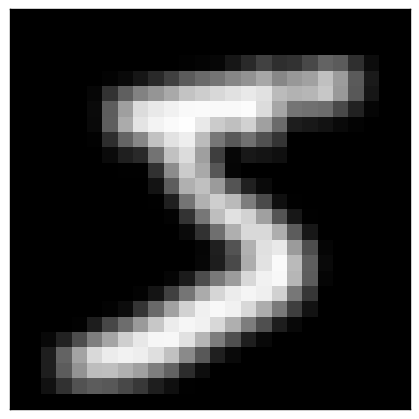

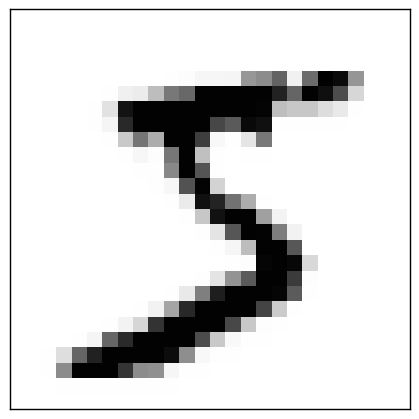

(1, 26, 26)

In [8]:
train_net()
nn.last_epoch = 0
print 'asd'

print nn[1].kernels
imshow(nn[1].output)
imshow(y[None])